in this notebook, we will use the preprocessed data using approach 2 to classify eyesopen, eyesclosed using the following method

Method 1
- classify using only the following channels [27, 28, 29, 30, 57, 58, 59 ,60] these are channels related to occipital

Method 2
- Use only the Oz channel

Method 3
- all occipital channels plus P3, P4

In [1]:
!pip install fastai timm -Uqq

     |████████████████████████████████| 187 kB 5.5 MB/s 
     |████████████████████████████████| 431 kB 44.3 MB/s 
     |████████████████████████████████| 56 kB 2.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/colab_notebooks/algovera/lynxhack

/content/drive/MyDrive/colab_notebooks/algovera/lynxhack


In [4]:
import timm
from timm import create_model
from timm.models.efficientnet_blocks import DepthwiseSeparableConv
from timm.models.layers import create_conv2d
from fastai.vision.all import *

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import pickle

In [5]:
df = pd.read_csv('approach2infos.csv')

In [6]:
df = df[df['label'].isin(['task-eyes closed', 'task-eyes open'])]

In [7]:
df_train = df[df['is_valid']==False]
df_val = df[df['is_valid']==True]

In [8]:
ss = pickle.load(open('ss_approach2.pkl', 'rb'))

In [33]:
class Block(nn.Module):
  def __init__(self,inplace):
      super().__init__()
      self.conv1=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=2,stride=2,padding=0)
      self.conv2=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=4,stride=2,padding=1)
      self.conv3=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=8,stride=2,padding=3)
      self.relu=nn.ReLU()

  def forward(self,x):
      x1=self.relu(self.conv1(x))
      x2=self.relu(self.conv2(x))
      x3=self.relu(self.conv3(x))
      x=torch.cat([x1,x3,x3],dim=1)
      return x


class ChronoNet(nn.Module):
  def __init__(self,channel):
      super().__init__()
      self.block1=Block(channel)
      self.block2=Block(96)
      self.block3=Block(96)
      self.gru1=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
      self.gru2=nn.GRU(input_size=32,hidden_size=32,batch_first=True)
      self.gru3=nn.GRU(input_size=64,hidden_size=32,batch_first=True)
      self.gru4=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
      self.gru_linear=nn.Linear(625,1)
      self.flatten=nn.Flatten()
      self.fc1=nn.Linear(32,2)
      self.relu=nn.ReLU()

  def forward(self,x):
      x=self.block1(x)
      x=self.block2(x)
      x=self.block3(x)
      x=x.permute(0,2,1)
      gru_out1,_=self.gru1(x)
      gru_out2,_=self.gru2(gru_out1)
      gru_out=torch.cat([gru_out1,gru_out2],dim=2)
      gru_out3,_=self.gru3(gru_out)
      gru_out=torch.cat([gru_out1,gru_out2,gru_out3],dim=2)
      #print('gru_out',gru_out.shape)
      linear_out=self.relu(self.gru_linear(gru_out.permute(0,2,1)))
      gru_out4,_=self.gru4(linear_out.permute(0,2,1))
      x=self.flatten(gru_out4)
      x=self.fc1(x)
      return x

## Method 1 with ChronoNet

In [34]:
include = [27, 28, 29, 30, 57, 58, 59 ,60] # only channels related to occipital

def read_eeg(fn):
    include = [27, 28, 29, 30, 57, 58, 59 ,60] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return x[include]
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [35]:
label_index = {
    'task-eyes closed':0, 
    'task-eyes open':1,       
}

In [36]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [37]:
x,y = dls.one_batch()

In [38]:
model = ChronoNet(8)   
apply_init(model, nn.init.kaiming_normal_)

In [39]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='chrononet')],
                metrics=accuracy
        ).to_fp16()

In [40]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.703452,0.688377,0.465517,00:26
1,0.693514,0.648676,0.775862,00:14
2,0.678733,0.580268,0.810345,00:14
3,0.652153,0.612029,0.603448,00:14
4,0.630647,0.485828,0.827586,00:14
5,0.597224,0.522725,0.741379,00:14
6,0.572119,0.536297,0.844828,00:14
7,0.556862,0.509785,0.775862,00:14
8,0.539805,0.495812,0.810345,00:14
9,0.515386,0.472514,0.810345,00:14


Better model found at epoch 0 with valid_loss value: 0.6883774399757385.
Better model found at epoch 1 with valid_loss value: 0.6486762762069702.
Better model found at epoch 2 with valid_loss value: 0.5802682042121887.
Better model found at epoch 4 with valid_loss value: 0.4858281910419464.
Better model found at epoch 9 with valid_loss value: 0.4725140929222107.


## Method 2 with ChronoNet

In [41]:
def read_eeg(fn):
    include = [29] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return x[include]
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [42]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [43]:
model = ChronoNet(1)   
apply_init(model, nn.init.kaiming_normal_)

In [44]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='chrononet_meth2')],
                metrics=accuracy
        ).to_fp16()

In [45]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.680020,0.671048,0.620690,00:20
1,0.670655,0.646566,0.620690,00:14
2,0.652577,0.618888,0.603448,00:16
3,0.618533,0.800426,0.551724,00:16
4,0.611953,0.605689,0.706897,00:18
5,0.577467,0.609273,0.724138,00:14
6,0.545230,0.699221,0.655172,00:14
7,0.515455,0.671403,0.672414,00:15
8,0.484395,0.806448,0.603448,00:14
9,0.455614,0.690662,0.724138,00:14


Better model found at epoch 0 with valid_loss value: 0.6710477471351624.
Better model found at epoch 1 with valid_loss value: 0.6465663313865662.
Better model found at epoch 2 with valid_loss value: 0.6188880205154419.
Better model found at epoch 4 with valid_loss value: 0.6056885719299316.


## Method 3 ChronoNet

In [49]:
def read_eeg(fn):
    include = [24, 27, 28, 29, 30, 54, 57, 58, 59 ,60] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return x[include]
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [50]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [51]:
model = ChronoNet(10)   
apply_init(model, nn.init.kaiming_normal_)

In [52]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='chrono_meth3')],
                metrics=accuracy
        ).to_fp16()

In [53]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.685457,0.703899,0.431034,00:14
1,0.679473,0.674935,0.637931,00:14
2,0.662783,0.682724,0.655172,00:14
3,0.646158,0.643744,0.637931,00:14
4,0.611722,0.601592,0.758621,00:14
5,0.608195,0.659525,0.689655,00:14
6,0.587786,0.764326,0.603448,00:14
7,0.564289,0.601797,0.706897,00:14
8,0.528349,0.653812,0.706897,00:14
9,0.526265,1.267902,0.603448,00:14


Better model found at epoch 0 with valid_loss value: 0.7038993835449219.
Better model found at epoch 1 with valid_loss value: 0.6749347448348999.
Better model found at epoch 3 with valid_loss value: 0.6437442302703857.
Better model found at epoch 4 with valid_loss value: 0.6015917658805847.


## Method 4 ChronoNet

In [54]:
def read_eeg(fn):
    # include = [24, 27, 28, 29, 30, 54, 57, 58, 59 ,60] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return x
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [55]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [56]:
model = ChronoNet(61)   
apply_init(model, nn.init.kaiming_normal_)

In [57]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='eeginception_meth3')],
                metrics=accuracy
        ).to_fp16()

In [58]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.704838,0.690524,0.500000,00:14
1,0.704297,0.703395,0.465517,00:14
2,0.697747,0.704920,0.500000,00:14
3,0.681199,0.752216,0.500000,00:14
4,0.675649,0.647247,0.672414,00:14
5,0.653062,0.677516,0.620690,00:14
6,0.630138,0.659116,0.637931,00:14
7,0.603104,0.605272,0.672414,00:14
8,0.577909,0.590964,0.689655,00:14
9,0.550050,0.672755,0.706897,00:14


Better model found at epoch 0 with valid_loss value: 0.6905242204666138.
Better model found at epoch 4 with valid_loss value: 0.6472469568252563.
Better model found at epoch 7 with valid_loss value: 0.6052717566490173.
Better model found at epoch 8 with valid_loss value: 0.5909635424613953.


In [59]:
interp = ClassificationInterpretation.from_learner(learn)

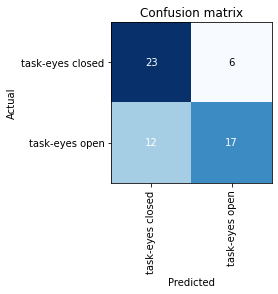

In [60]:
interp.plot_confusion_matrix()